In [ ]:
# !pip install torch
# !pip install matplotlib
# !pip install scikit-learn
!pip install datasets
# !pip install transformers
# !pip install 'accelerate>=0.26.0'
# !pip install transformers[torch]
# !pip uninstall nvidia-cublas-cu11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import matthews_corrcoef, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [ ]:
# torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.9"

In [ ]:
device = torch.device('cuda')
# torch.cuda.is_available()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ds_arg = pd.read_csv('/content/drive/MyDrive/Fall 2024/PUBH 8885 - Computational Biology/Project/Data/ShortReads.csv')
ds_arg.head()

,id,type,Sequence
0,B9J113,beta_lactam,GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...
1,B9J113,beta_lactam,AAACAATCGCTTATCGACCTAACGAAAGGTTTGCCTTTGCATCAAC...
2,B9J113,beta_lactam,AGATGAAGTTATTACTTATACGAAAGAAGACTTAGTGGATTATTCA...
3,B9J113,beta_lactam,GCTGCTGTTCGTTACAGTGATAATACTGCAGGGAACATTTTATTTC...
4,B9J113,beta_lactam,GGGTTACTATGTCTGATCGCTTTGAAACAGAGTTAAACGAAGCTAT...


In [ ]:
# number of unique drug resistance type
print("# Unique Resistance Types:", len(set(ds_arg['type'])),"\n\nUnique Resistance Types:", ds_arg['type'].unique())

# Unique Resistance Types: 15 

Unique Resistance Types: ['beta_lactam' 'bacitracin' 'chloramphenicol' 'aminoglycoside'
 'macrolide-lincosamide-streptogramin' 'multidrug' 'polymyxin'
 'fosfomycin' 'sulfonamide' 'glycopeptide' 'mupirocin' 'trimethoprim'
 'quinolone' 'fosmidomycin' 'tetracycline']


In [ ]:
max_length = ds_arg['Sequence'].str.len().max()
max_length

100

In [ ]:
ds_arg.columns

Index(['id', 'type', 'Sequence'], dtype='object')

In [ ]:
# Create label encoder for drug resistance types
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(ds_arg['type'])

In [ ]:
labels

array([2, 2, 2, ..., 7, 7, 7])

In [ ]:
# Split data
sequences = ds_arg['Sequence'].values

# Get class counts
class_counts = np.bincount(labels)

# Find classes with only one sample
single_sample_classes = np.where(class_counts == 1)[0]

In [ ]:
#If there are classes with only one sample remove them from the dataset
if len(single_sample_classes) > 0:
  print(f"Removing classes with only one sample: {single_sample_classes}")
  # Create a mask to select samples not belonging to single-sample classes
  mask = ~np.isin(labels, single_sample_classes)
  sequences = sequences[mask]
  labels = labels[mask]

In [ ]:
dataset = pd.DataFrame({
    'sequence': sequences,
    'label': labels
})
print(dataset)

                                                sequence  label
0      GTGAAACATAAAAATCAGGCGACGCATAAAGAGTTCTCTCAACTTG...      2
1      AAACAATCGCTTATCGACCTAACGAAAGGTTTGCCTTTGCATCAAC...      2
2      AGATGAAGTTATTACTTATACGAAAGAAGACTTAGTGGATTATTCA...      2
3      GCTGCTGTTCGTTACAGTGATAATACTGCAGGGAACATTTTATTTC...      2
4      GGGTTACTATGTCTGATCGCTTTGAAACAGAGTTAAACGAAGCTAT...      2
...                                                  ...    ...
96140  GTGGCTGAACTCCATTACTGTCAGGGTGAAAGAAGGATTTGACAGC...      7
96141  GATTTCTTTACCTGGAACATGGACGGCGTCTTGAAAACCGTTGAAA...      7
96142  TGGTGGGCGGTATTGGTGTAATGAATATTATGCTGGTGTCAGTGAC...      7
96143  TGTTTTGCAACAGTTCCTGATCGAAGCCGTGCTGGTTTGCCTGGTC...      7
96144  TTCTTACCCGGCTGGGAGATTGGTTTTTCACCGTTGGCGCTGCTGC...      7

[96145 rows x 2 columns]


In [ ]:
# Create Train Test split
train_sequences, test_sequences, train_labels, test_labels = train_test_split(dataset['sequence'], dataset['label'], test_size=0.1, random_state=42)

train_sequences, validation_sequences, train_labels, validation_labels = train_test_split(train_sequences, train_labels, test_size=0.1, random_state=42)

print("Train Size:",len(train_sequences), "\nValidation Size:", len(validation_sequences), "\nTest Size:", len(test_sequences))

Train Size: 77877 
Validation Size: 8653 
Test Size: 9615


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-100m-multi-species")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

In [ ]:
ds_train = Dataset.from_dict({"sequence": train_sequences,'labels':train_labels})
ds_validation = Dataset.from_dict({"sequence": validation_sequences,'labels':validation_labels})
ds_test = Dataset.from_dict({"sequence": test_sequences,'labels':test_labels})

In [ ]:
# Tokenize the dataset
def tokenize_function(data):
    return tokenizer(
        data['sequence'],
        padding='max_length',
        max_length=128,
        truncation=True,       # Truncate if longer than max_length
        return_tensors='pt'    # Return pytorch tensors
    )

In [ ]:
tokenized_datasets_train = ds_train.map(
    tokenize_function,
    batched=True,
    remove_columns=['sequence']
)
tokenized_datasets_validation = ds_validation.map(
    tokenize_function,
    batched=True,
    remove_columns=['sequence']
)
tokenized_datasets_test = ds_test.map(
    tokenize_function,
    batched=True,
    remove_columns=['sequence']
)

Map:   0%|          | 0/77877 [00:00<?, ? examples/s]

Map:   0%|          | 0/8653 [00:00<?, ? examples/s]

Map:   0%|          | 0/9615 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "InstaDeepAI/nucleotide-transformer-v2-100m-multi-species",
    num_labels=len(set(ds_arg['type'])),
    trust_remote_code=True
)

config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

esm_config.py:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-100m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/392M [00:00<?, ?B/s]

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-100m-multi-species and are newly initialized: ['classifier.dense.bias', 

In [ ]:
def compute_metrics(eval_pred):
    """Computes F1 score for multi-class classification"""
    labels = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=-1)

#    precision, recall, f1, support = precision_recall_fscore_support(labels, predictions, average=None, labels=range(n_labels))

    micro_precision, micro_recall, micro_f1, micro_support = precision_recall_fscore_support(labels, predictions, average='micro')

    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')

    weighted_precision, weighted_recall, weighted_f1, weighted_support = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        # 'precision': precision,
        # 'recall': recall,
        # 'f1': f1,
        'micro_precision': micro_precision,
        'macro_precision': macro_precision,
        'weighted_precision': weighted_precision,
        'micro_recall': micro_recall,
        'macro_recall': macro_recall,
        'weighted_recall': weighted_recall,
        'micro_f1': micro_f1,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    }

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

In [ ]:
training_Args = TrainingArguments(
    "/content/drive/MyDrive/Fall 2024/PUBH 8885 - Computational Biology/Project/models/nuc_arg_short_readv2",
    remove_unused_columns=False,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2.5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps= 8,
    per_device_eval_batch_size= 32,
    num_train_epochs= 4,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="eval_weighted_f1",
    label_names=["labels"],
    dataloader_drop_last=True,
    fp16=True
)

In [ ]:
trainer = Trainer(
    model.to(device),
    training_Args,
    data_collator=data_collator,
    train_dataset = tokenized_datasets_train,
    eval_dataset = tokenized_datasets_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-32-91bdbc5f0638>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_results = trainer.train()
#0ee50b9af42a643d0775410d9fce2677e382baf2

Epoch,Training Loss,Validation Loss,Micro Precision,Macro Precision,Weighted Precision,Micro Recall,Macro Recall,Weighted Recall,Micro F1,Macro F1,Weighted F1
0,0.939400,0.845483,0.770255,0.323590,0.749165,0.770255,0.306967,0.770255,0.770255,0.308256,0.755768
1,0.688100,0.720991,0.812963,0.451447,0.806641,0.812963,0.387017,0.812963,0.812963,0.403819,0.805004
2,0.553500,0.675450,0.824769,0.449470,0.822969,0.824769,0.428615,0.824769,0.824769,0.436918,0.823285
3,0.444100,0.683810,0.827546,0.468374,0.825598,0.827546,0.437203,0.827546,0.827546,0.450169,0.825736


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
trainer.save_state()
print(trainer.state.log_history)

[{'loss': 1.6312, 'grad_norm': 56.5152702331543, 'learning_rate': 2.294407894736842e-05, 'epoch': 0.32881216605014385, 'step': 100}, {'loss': 1.1348, 'grad_norm': 25.111013412475586, 'learning_rate': 2.0888157894736843e-05, 'epoch': 0.6576243321002877, 'step': 200}, {'loss': 0.9394, 'grad_norm': 26.142438888549805, 'learning_rate': 1.8832236842105263e-05, 'epoch': 0.9864364981504316, 'step': 300}, {'eval_loss': 0.8454831838607788, 'eval_micro_precision': 0.7702546296296297, 'eval_macro_precision': 0.32358972094404553, 'eval_weighted_precision': 0.749165217714151, 'eval_micro_recall': 0.7702546296296297, 'eval_macro_recall': 0.30696712181474184, 'eval_weighted_recall': 0.7702546296296297, 'eval_micro_f1': 0.7702546296296297, 'eval_macro_f1': 0.3082563827875494, 'eval_weighted_f1': 0.7557680928301825, 'eval_runtime': 32.1611, 'eval_samples_per_second': 269.052, 'eval_steps_per_second': 8.426, 'epoch': 0.9995889847924373, 'step': 304}, {'loss': 0.778, 'grad_norm': 31.7321834564209, 'learn

In [ ]:
curve_evaluation_f1_score = [
    [a['step'], a['eval_weighted_f1']]
    for a in trainer.state.log_history
    if 'eval_weighted_f1' in a.keys()
]

In [ ]:
curve_evaluation_f1_score

[[304, 0.7557680928301825],
 [608, 0.8050040647878027],
 [912, 0.8232850111902783],
 [1216, 0.8257364797139064]]

In [ ]:
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

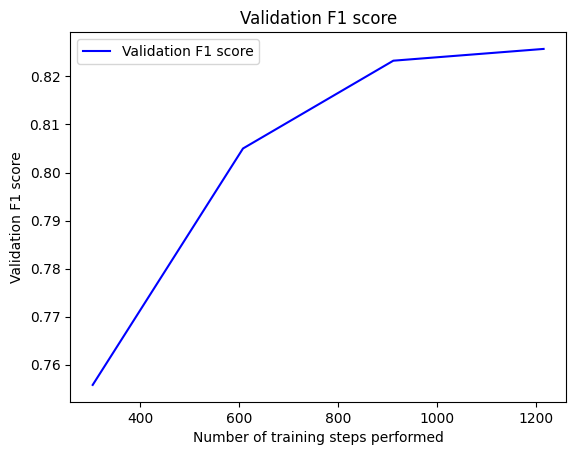

In [ ]:
plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
plt.title('Validation F1 score')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend()
plt.show()

## Short Read Test Data

In [ ]:
test_results = trainer.predict(tokenized_datasets_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("Test Metrics:", test_results.metrics)

Test Metrics: {'test_loss': 0.6644510626792908, 'test_micro_precision': 0.8319791666666667, 'test_macro_precision': 0.4608115099488821, 'test_weighted_precision': 0.8294596746226569, 'test_micro_recall': 0.8319791666666667, 'test_macro_recall': 0.434633666201421, 'test_weighted_recall': 0.8319791666666667, 'test_micro_f1': 0.8319791666666667, 'test_macro_f1': 0.44557519529558987, 'test_weighted_f1': 0.8301766131178652, 'test_runtime': 41.4932, 'test_samples_per_second': 231.725, 'test_steps_per_second': 7.254}


In [ ]:
predicted_classes = np.argmax(test_results.predictions, axis=1)

In [ ]:
# Optionally, compare predictions with true labels
true_labels = test_results.label_ids
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       373
           1       0.89      0.88      0.88      3194
           2       0.86      0.87      0.86      3105
           3       0.68      0.59      0.63       218
           4       0.80      0.57      0.66       111
           6       0.00      0.00      0.00        10
           7       0.77      0.82      0.79      1307
           8       0.56      0.47      0.51       162
           9       0.00      0.00      0.00         7
          10       0.79      0.83      0.81      1107
          11       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1

    accuracy                           0.83      9600
   macro avg       0.46      0.43      0.45      9600
weighted avg       0.83      0.83      0.83      9600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualizations

In [ ]:
print("Number of classes in test_labels:", len(np.unique(true_labels)))
print("Number of classes in label_encoder:", len(label_encoder.classes_))

Number of classes in test_labels: 13
Number of classes in label_encoder: 15


In [ ]:
# Get the unique labels from both true and predicted labels
unique_labels = np.unique(np.concatenate((true_labels, predicted_classes)))

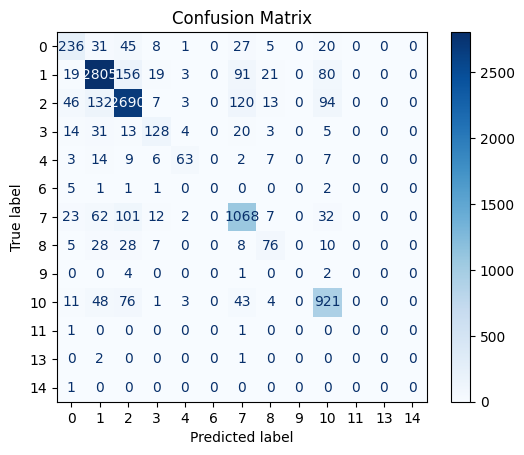

In [ ]:
cm = confusion_matrix(true_labels, predicted_classes, labels=unique_labels)  # Specify labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)  # Updated labels
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
labels = label_encoder.classes_
x = np.arange(len(labels))  # Class indices

# precision = [test_results.metrics['test_micro_precision'], test_results.metrics['test_macro_precision'], test_results.metrics['test_weighted_precision']]
# recall = [test_results.metrics['test_micro_recall'], test_results.metrics['test_macro_recall'], test_results.metrics['test_weighted_recall']]
# f1 = [test_results.metrics['test_micro_f1'], test_results.metrics['test_macro_f1'], test_results.metrics['test_weighted_f1']]

precision = test_results.metrics['test_weighted_precision']
recall = test_results.metrics['test_weighted_recall']
f1 = test_results.metrics['test_weighted_f1']


In [ ]:
class_report = classification_report(true_labels, predicted_classes, target_names=unique_labels, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print(class_report_df)

              precision    recall  f1-score      support
0              0.648352  0.632708  0.640434   373.000000
1              0.889347  0.878209  0.883743  3194.000000
2              0.861351  0.866345  0.863841  3105.000000
3              0.677249  0.587156  0.628993   218.000000
4              0.797468  0.567568  0.663158   111.000000
6              0.000000  0.000000  0.000000    10.000000
7              0.772793  0.817138  0.794347  1307.000000
8              0.558824  0.469136  0.510067   162.000000
9              0.000000  0.000000  0.000000     7.000000
10             0.785166  0.831978  0.807895  1107.000000
11             0.000000  0.000000  0.000000     2.000000
13             0.000000  0.000000  0.000000     3.000000
14             0.000000  0.000000  0.000000     1.000000
accuracy       0.831979  0.831979  0.831979     0.831979
macro avg      0.460812  0.434634  0.445575  9600.000000
weighted avg   0.829460  0.831979  0.830177  9600.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
class_metrics = class_report_df.iloc[:-3, :]  # Excluding 'accuracy', 'macro avg', 'weighted avg'
precision = class_metrics['precision']
recall = class_metrics['recall']
f1 = class_metrics['f1-score']
classes = class_metrics.index

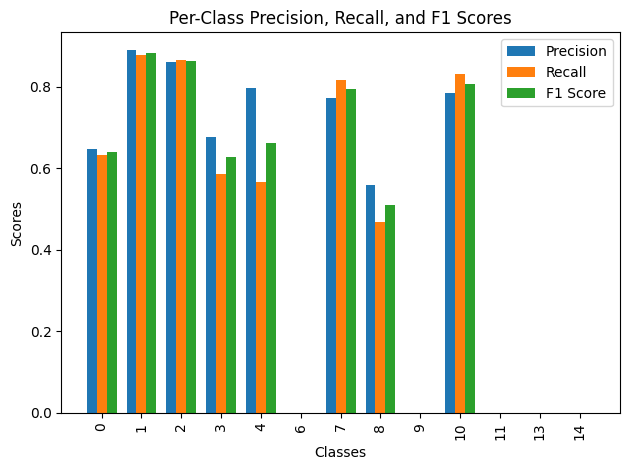

In [ ]:
x = np.arange(len(classes))  # Class indices
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("Per-Class Precision, Recall, and F1 Scores")
plt.xticks(x, classes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
trainer.state.log_history

[{'loss': 1.6312,
  'grad_norm': 56.5152702331543,
  'learning_rate': 2.294407894736842e-05,
  'epoch': 0.32881216605014385,
  'step': 100},
 {'loss': 1.1348,
  'grad_norm': 25.111013412475586,
  'learning_rate': 2.0888157894736843e-05,
  'epoch': 0.6576243321002877,
  'step': 200},
 {'loss': 0.9394,
  'grad_norm': 26.142438888549805,
  'learning_rate': 1.8832236842105263e-05,
  'epoch': 0.9864364981504316,
  'step': 300},
 {'eval_loss': 0.8454831838607788,
  'eval_micro_precision': 0.7702546296296297,
  'eval_macro_precision': 0.32358972094404553,
  'eval_weighted_precision': 0.749165217714151,
  'eval_micro_recall': 0.7702546296296297,
  'eval_macro_recall': 0.30696712181474184,
  'eval_weighted_recall': 0.7702546296296297,
  'eval_micro_f1': 0.7702546296296297,
  'eval_macro_f1': 0.3082563827875494,
  'eval_weighted_f1': 0.7557680928301825,
  'eval_runtime': 32.1611,
  'eval_samples_per_second': 269.052,
  'eval_steps_per_second': 8.426,
  'epoch': 0.9995889847924373,
  'step': 304}

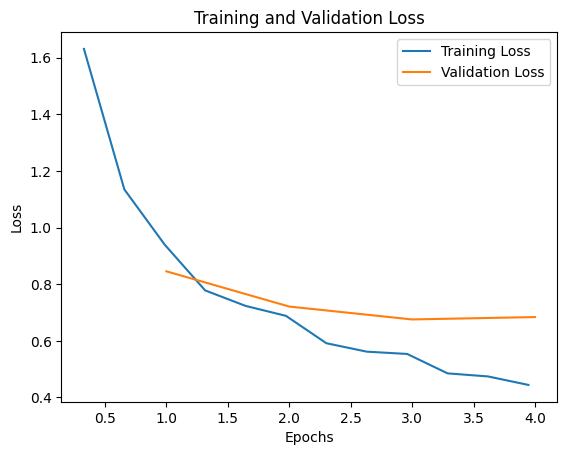

In [ ]:
training_history = trainer.state.log_history

# Plot training loss
# Get epoch numbers for every training loss entry
epochs_train = [log["epoch"] for log in training_history if "loss" in log]
loss = [log["loss"] for log in training_history if "loss" in log]

# Get epoch numbers ONLY for iterations with eval_loss
epochs_eval = [log["epoch"] for log in training_history if "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in training_history if "eval_loss" in log]

plt.plot(epochs_train, loss, label="Training Loss")
plt.plot(epochs_eval, eval_loss, label="Validation Loss") # Using epochs_eval for validation loss
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
training_Args = TrainingArguments(
    "/content/drive/MyDrive/Fall 2024/PUBH 8885 - Computational Biology/Project/models/nuc_arg_short_readv2.1",
    remove_unused_columns=False,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2.5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps= 8,
    per_device_eval_batch_size= 32,
    num_train_epochs= 1,
    logging_steps= 100,
    load_best_model_at_end=True,  # Keep the best model according to the evaluation
    metric_for_best_model="eval_weighted_f1",
    label_names=["labels"],
    dataloader_drop_last=True,
    fp16=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model.to(device),
    training_Args,
    data_collator=data_collator,
    train_dataset = tokenized_datasets_train,
    eval_dataset = tokenized_datasets_validation,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-62-91bdbc5f0638>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_results

TrainOutput(global_step=1216, training_loss=0.7467214963153789, metrics={'train_runtime': 3102.9134, 'train_samples_per_second': 100.392, 'train_steps_per_second': 0.392, 'total_flos': 2.2147108316381184e+16, 'train_loss': 0.7467214963153789, 'epoch': 3.998355939169749})

In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Micro Precision,Macro Precision,Weighted Precision,Micro Recall,Macro Recall,Weighted Recall,Micro F1,Macro F1,Weighted F1
0,0.452600,0.691085,0.820718,0.451229,0.819885,0.820718,0.432314,0.820718,0.820718,0.439759,0.819736


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
trainer_save = [{'loss': 1.6312,
  'grad_norm': 56.5152702331543,
  'learning_rate': 2.294407894736842e-05,
  'epoch': 0.32881216605014385,
  'step': 100},
 {'loss': 1.1348,
  'grad_norm': 25.111013412475586,
  'learning_rate': 2.0888157894736843e-05,
  'epoch': 0.6576243321002877,
  'step': 200},
 {'loss': 0.9394,
  'grad_norm': 26.142438888549805,
  'learning_rate': 1.8832236842105263e-05,
  'epoch': 0.9864364981504316,
  'step': 300},
 {'eval_loss': 0.8454831838607788,
  'eval_micro_precision': 0.7702546296296297,
  'eval_macro_precision': 0.32358972094404553,
  'eval_weighted_precision': 0.749165217714151,
  'eval_micro_recall': 0.7702546296296297,
  'eval_macro_recall': 0.30696712181474184,
  'eval_weighted_recall': 0.7702546296296297,
  'eval_micro_f1': 0.7702546296296297,
  'eval_macro_f1': 0.3082563827875494,
  'eval_weighted_f1': 0.7557680928301825,
  'eval_runtime': 32.1611,
  'eval_samples_per_second': 269.052,
  'eval_steps_per_second': 8.426,
  'epoch': 0.9995889847924373,
  'step': 304},
 {'loss': 0.778,
  'grad_norm': 31.7321834564209,
  'learning_rate': 1.6776315789473686e-05,
  'epoch': 1.3152486642005754,
  'step': 400},
 {'loss': 0.7233,
  'grad_norm': 36.89674377441406,
  'learning_rate': 1.4720394736842105e-05,
  'epoch': 1.6440608302507194,
  'step': 500},
 {'loss': 0.6881,
  'grad_norm': 27.113405227661133,
  'learning_rate': 1.2664473684210526e-05,
  'epoch': 1.972872996300863,
  'step': 600},
 {'eval_loss': 0.7209905982017517,
  'eval_micro_precision': 0.812962962962963,
  'eval_macro_precision': 0.4514466423411687,
  'eval_weighted_precision': 0.8066408422610873,
  'eval_micro_recall': 0.812962962962963,
  'eval_macro_recall': 0.3870169668496628,
  'eval_weighted_recall': 0.812962962962963,
  'eval_micro_f1': 0.812962962962963,
  'eval_macro_f1': 0.4038194648290547,
  'eval_weighted_f1': 0.8050040647878027,
  'eval_runtime': 32.2396,
  'eval_samples_per_second': 268.397,
  'eval_steps_per_second': 8.406,
  'epoch': 1.9991779695848746,
  'step': 608},
 {'loss': 0.5914,
  'grad_norm': 36.23032760620117,
  'learning_rate': 1.0608552631578949e-05,
  'epoch': 2.301685162351007,
  'step': 700},
 {'loss': 0.5616,
  'grad_norm': 26.161983489990234,
  'learning_rate': 8.552631578947368e-06,
  'epoch': 2.630497328401151,
  'step': 800},
 {'loss': 0.5535,
  'grad_norm': 34.090694427490234,
  'learning_rate': 6.49671052631579e-06,
  'epoch': 2.9593094944512948,
  'step': 900},
 {'eval_loss': 0.6754504442214966,
  'eval_micro_precision': 0.8247685185185185,
  'eval_macro_precision': 0.449469641553569,
  'eval_weighted_precision': 0.8229685941178848,
  'eval_micro_recall': 0.8247685185185185,
  'eval_macro_recall': 0.4286150204922574,
  'eval_weighted_recall': 0.8247685185185185,
  'eval_micro_f1': 0.8247685185185185,
  'eval_macro_f1': 0.43691774562937663,
  'eval_weighted_f1': 0.8232850111902783,
  'eval_runtime': 32.1249,
  'eval_samples_per_second': 269.355,
  'eval_steps_per_second': 8.436,
  'epoch': 2.998766954377312,
  'step': 912},
 {'loss': 0.4849,
  'grad_norm': 40.638362884521484,
  'learning_rate': 4.4407894736842105e-06,
  'epoch': 3.2881216605014387,
  'step': 1000},
 {'loss': 0.4741,
  'grad_norm': 30.844663619995117,
  'learning_rate': 2.384868421052632e-06,
  'epoch': 3.6169338265515822,
  'step': 1100},
 {'loss': 0.4441,
  'grad_norm': 26.968608856201172,
  'learning_rate': 3.2894736842105264e-07,
  'epoch': 3.945745992601726,
  'step': 1200},
 {'eval_loss': 0.6838096380233765,
  'eval_micro_precision': 0.8275462962962963,
  'eval_macro_precision': 0.46837386836976236,
  'eval_weighted_precision': 0.8255976597277161,
  'eval_micro_recall': 0.8275462962962963,
  'eval_macro_recall': 0.4372025469059783,
  'eval_weighted_recall': 0.8275462962962963,
  'eval_micro_f1': 0.8275462962962963,
  'eval_macro_f1': 0.4501691015818631,
  'eval_weighted_f1': 0.8257364797139064,
  'eval_runtime': 34.5877,
  'eval_samples_per_second': 250.175,
  'eval_steps_per_second': 7.835,
  'epoch': 3.998355939169749,
  'step': 1216},
 {'train_runtime': 3102.9134,
  'train_samples_per_second': 100.392,
  'train_steps_per_second': 0.392,
  'total_flos': 2.2147108316381184e+16,
  'train_loss': 0.7467214963153789,
  'epoch': 3.998355939169749,
  'step': 1216},
{'loss': 0.508,
  'grad_norm': 51.576847076416016,
  'learning_rate': 1.6776315789473686e-05,
  'epoch': 0.32881216605014385,
  'step': 1300},
 {'loss': 0.4639,
  'grad_norm': 41.97359848022461,
  'learning_rate': 8.634868421052631e-06,
  'epoch': 0.6576243321002877,
  'step': 1500},
 {'loss': 0.4526,
  'grad_norm': 40.50881576538086,
  'learning_rate': 4.111842105263158e-07,
  'epoch': 0.9864364981504316,
  'step': 1600},
 {'eval_loss': 0.6910848021507263,
  'eval_micro_precision': 0.8207175925925926,
  'eval_macro_precision': 0.4512294440626366,
  'eval_weighted_precision': 0.8198848821559097,
  'eval_micro_recall': 0.8207175925925926,
  'eval_macro_recall': 0.43231358525616836,
  'eval_weighted_recall': 0.8207175925925926,
  'eval_micro_f1': 0.8207175925925926,
  'eval_macro_f1': 0.439759165794376,
  'eval_weighted_f1': 0.8197355365134286,
  'eval_runtime': 34.4821,
  'eval_samples_per_second': 250.942,
  'eval_steps_per_second': 7.859,
  'epoch': 0.9995889847924373,
  'step': 1620},
 {'train_runtime': 789.8819,
  'train_samples_per_second': 98.593,
  'train_steps_per_second': 0.385,
  'total_flos': 5536777079095296.0,
  'train_loss': 0.4744202627947456,
  'epoch': 0.9995889847924373,
  'step': 1620}]

In [ ]:
curve_evaluation_f1_score = [
    [a['step'], a['eval_weighted_f1']]
    for a in trainer_save
    if 'eval_weighted_f1' in a.keys()
]

In [ ]:
eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
steps = [c[0] for c in curve_evaluation_f1_score]

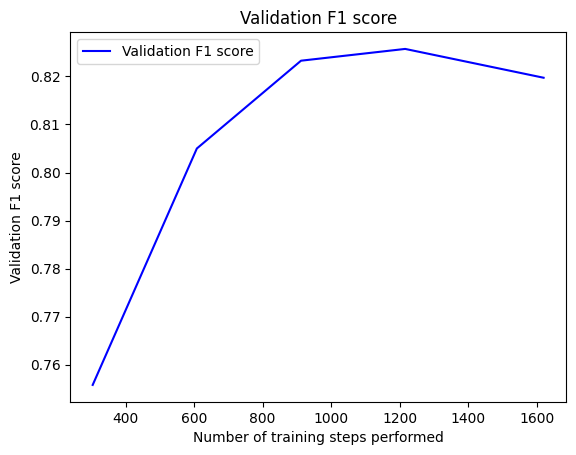

In [ ]:
plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
plt.title('Validation F1 score')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation F1 score')
plt.legend()
plt.show()